In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
from plotnine import *
from datetime import datetime
pd.set_option("display.precision", 4)

In [3]:
# import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 200

# 0. Setup

In [6]:
# save private key to: ../srv/mykey/.quandlapikey
# loading private key
quandl.read_key("../srv/mykey/.quandlapikey")
MonthSymbolList = ["H", "M", "U", "Z"]
start_date = "2020-12-3"
end_date = "2022-08-31"
OptionCodeList = [m+y for y in ("2021", "2022") for m in MonthSymbolList][:-2]
plt.style.use('bmh') # https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html

In [4]:
try:
    # Do not recreate if it already exists
    fetch_quandl
    print("fetch_quandl already defined")
except NameError:
    @functools.lru_cache(maxsize=16)
    def fetch_quandl(my_sec):
        print("Fetching from Quandl")
        qdata = quandl.get(my_sec)
        return qdata
    print("fetch_quandl has now been newly defined")

fetch_quandl has now been newly defined


In [5]:
def get_futures_data(name, option_code_list, s=start_date, e=end_date):
    Future = pd.DataFrame()
    Dtt = pd.DataFrame()
    f_ls, dtt_ls = [], []
    print(name)
    for code in option_code_list:
        sec_name = "OWF/%s_%s_IVM" % (name, code)
        print("Getting data: " + sec_name)
        data = quandl.get(sec_name, start_date=s, 
                      end_date=e)
        f_ls.append(data.Future)
        dtt_ls.append(data.DtT)
    Future = pd.concat(f_ls, axis=1, join="outer")
    Dtt = pd.concat(dtt_ls, axis=1, join="outer")
    Future.columns = option_code_list
    Dtt.columns = option_code_list
    return Future, Dtt

In [64]:
def cal_sec_mon_future(name, option_code_list, s, e, boundary=30):
    future, dtt =  get_futures_data(name, option_code_list, s, e)
    df = dtt[dtt > boundary]
    ls = df.idxmin(axis=1)
    future_price = pd.DataFrame(columns=[name], index=future.index)
    for idx, col in ls.items():
        try:
            future_price.loc[idx, name] = future.loc[idx, col]
        except KeyError:
            continue
    return future_price.dropna()

# 1. Data

In [65]:
# Student ID: 12375213
# 1. ICE_B_B versus ICE_G_G×0.1147
# 3. CBT_FV_FV versus CBT_TU_TU × 1.1066
# W, X; Y, Z
# X-W; Z-Y
ICE_B_B = cal_sec_mon_future("ICE_B_B", OptionCodeList, s=start_date, e=end_date)
ICE_G_G = cal_sec_mon_future("ICE_G_G", OptionCodeList, s=start_date, e=end_date)
ICE_B_B_ICE_G_G = ICE_B_B.merge(ICE_G_G, left_index=True, right_index=True)

CBT_FV_FV = cal_sec_mon_future("CBT_FV_FV", OptionCodeList, s=start_date, e=end_date)
CBT_TU_TU = cal_sec_mon_future("CBT_TU_TU", OptionCodeList, s=start_date, e=end_date)
CBT_FV_FV_CBT_TU_TU = CBT_FV_FV.merge(CBT_TU_TU, left_index=True, right_index=True)

ICE_B_B
Getting data: OWF/ICE_B_B_H2021_IVM
Getting data: OWF/ICE_B_B_M2021_IVM
Getting data: OWF/ICE_B_B_U2021_IVM
Getting data: OWF/ICE_B_B_Z2021_IVM
Getting data: OWF/ICE_B_B_H2022_IVM
Getting data: OWF/ICE_B_B_M2022_IVM
ICE_G_G
Getting data: OWF/ICE_G_G_H2021_IVM
Getting data: OWF/ICE_G_G_M2021_IVM
Getting data: OWF/ICE_G_G_U2021_IVM
Getting data: OWF/ICE_G_G_Z2021_IVM
Getting data: OWF/ICE_G_G_H2022_IVM
Getting data: OWF/ICE_G_G_M2022_IVM
CBT_FV_FV
Getting data: OWF/CBT_FV_FV_H2021_IVM
Getting data: OWF/CBT_FV_FV_M2021_IVM
Getting data: OWF/CBT_FV_FV_U2021_IVM
Getting data: OWF/CBT_FV_FV_Z2021_IVM
Getting data: OWF/CBT_FV_FV_H2022_IVM
Getting data: OWF/CBT_FV_FV_M2022_IVM
CBT_TU_TU
Getting data: OWF/CBT_TU_TU_H2021_IVM
Getting data: OWF/CBT_TU_TU_M2021_IVM
Getting data: OWF/CBT_TU_TU_U2021_IVM
Getting data: OWF/CBT_TU_TU_Z2021_IVM
Getting data: OWF/CBT_TU_TU_H2022_IVM
Getting data: OWF/CBT_TU_TU_M2022_IVM


In [139]:
ICE_B_B_ICE_G_G.tail()

,ICE_B_B,ICE_G_G
Date,,
2022-03-23,117.75,1054.25
2022-03-24,115.3,1045.25
2022-03-25,117.37,1047.5
2022-03-28,109.49,999.25
2022-03-29,107.71,962.75


In [140]:
CBT_FV_FV_CBT_TU_TU.tail()

,CBT_FV_FV,CBT_TU_TU
Date,,
2022-05-13,112.9609,105.6813
2022-05-16,113.2812,105.7422
2022-05-17,112.6719,105.5187
2022-05-18,112.9141,105.5859
2022-05-19,113.1406,105.6969


In [105]:
S1 = ICE_B_B_ICE_G_G['ICE_G_G'] * 0.1147 - ICE_B_B_ICE_G_G['ICE_B_B']
S1 = S1.to_frame("spread")
S1["spread"] = S1["spread"].astype("float64")

In [106]:
S2 = CBT_FV_FV_CBT_TU_TU["CBT_TU_TU"] * 1.1066 - CBT_FV_FV_CBT_TU_TU["CBT_FV_FV"]
S2 = S2.to_frame("spread")
S2["spread"] = S2["spread"].astype("float64")

# 2. Analysis
## 2.0 Check for data matching

In [141]:
print("ICE_B_B - ICE_G_G")
S1.loc[["2021-09-28", "2021-09-29", "2021-11-10"]]

ICE_B_B - ICE_G_G


,spread
Date,
2021-09-28,-2.6767
2021-09-29,0.0387
2021-11-10,-0.0780


In [142]:
print("CBT_TU_TU - CBT_FV_FV")
S2.loc[["2021-11-25", "2021-11-26"]]

CBT_TU_TU - CBT_FV_FV


,spread
Date,
2021-11-25,0.1563
2021-11-26,-0.1819


## 2.1 Descriptive Statistics and Patterns

In [109]:
def plot_lines(data, x, y, title):
    fig, ax = plt.subplots()
    ax.plot(data)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    plt.legend(data.columns)
    fig.autofmt_xdate()
    plt.show()

def plot_hist(data, title, buckets=50):
    fig, axs = plt.subplots()

    axs.hist(S1, buckets, density=True, histtype='stepfilled',
                alpha=0.75)
    axs.set_title(title)
    plt.show()

In [143]:
S1.describe()

,spread
count,340.0000
mean,-1.9862
std,2.4997
min,-6.5090
25%,-3.5535
50%,-2.6970
75%,-0.6955
max,12.2006


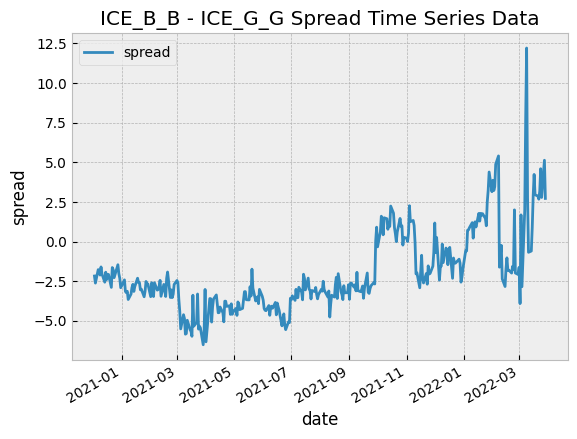

In [111]:
plot_lines(S1, "date", "spread", "ICE_B_B - ICE_G_G Spread Time Series Data")

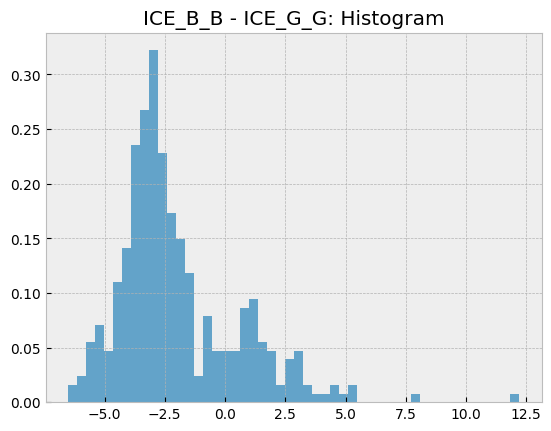

In [112]:
plot_hist(S1, "Histogram: ICE_B_B - ICE_G_G", buckets=50)

In [144]:
S2.describe()

,spread
count,380.0000
mean,-0.8056
std,2.1035
min,-3.9325
25%,-2.0340
50%,-1.5056
75%,0.2539
max,4.4609


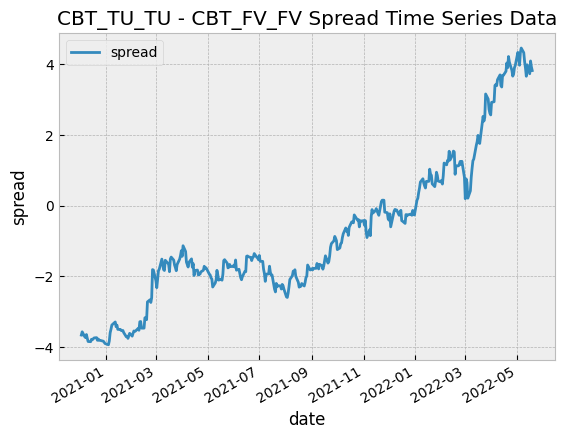

In [113]:
plot_lines(S2, "date", "spread", "CBT_TU_TU - CBT_FV_FV Spread Time Series Data")

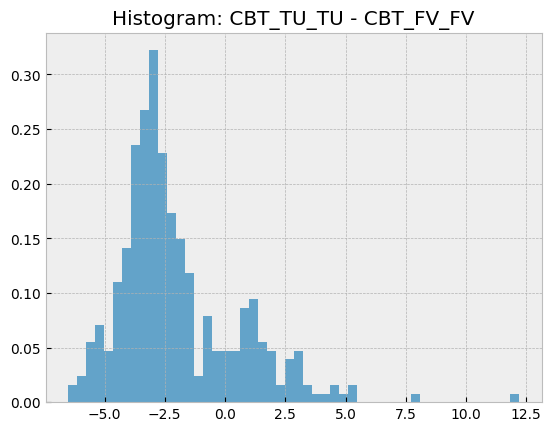

In [114]:
plot_hist(S1, "Histogram: CBT_TU_TU - CBT_FV_FV", buckets=50)

## 2.2 Moving Average Analysis

In [134]:
def plot_box(data, title, labels):
    fig, ax = plt.subplots()
    ax.boxplot(data.dropna())
    ax.set_title(title)
    ax.set_xticks([y + 1 for y in range(data.shape[1])],
                    labels=labels)
    ax.set_xlabel('Different N(d)')
    ax.set_ylabel('Spread diviation to moving average')
    plt.show()

In [122]:
RollingNs = [10, 30, 60, 120]
def cal_moving_avg(dat, rolling_days):
    data = dat.copy()
    for day in rolling_days:
        name = "%d D average" % day
        data[name] = dat.rolling(day).mean()
    return data

In [123]:
S1_avg = cal_moving_avg(S1, RollingNs)
S2_avg = cal_moving_avg(S2, RollingNs)

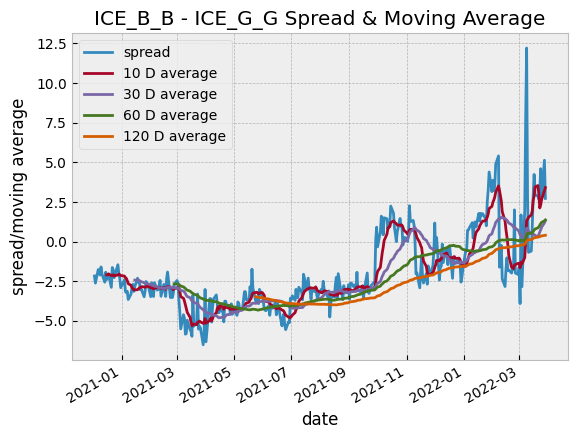

In [124]:
plot_lines(S1_avg, "date", "spread/moving average", "ICE_B_B - ICE_G_G Spread & Moving Average")

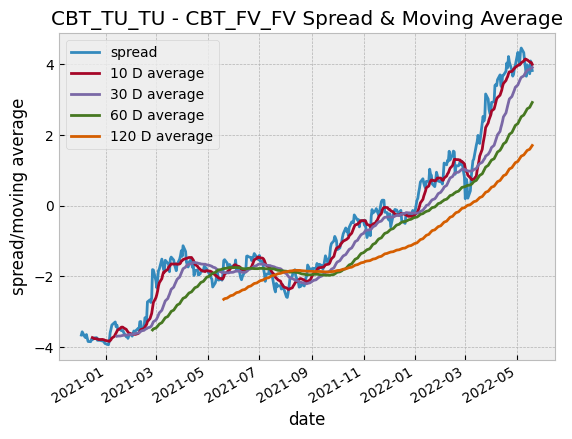

In [34]:
plot_lines(S2_avg, "date", "spread/moving average", "CBT_TU_TU - CBT_FV_FV Spread & Moving Average")

### 2.2.1 Difference between Moving Average and Spread

In [145]:
D1 = S1_avg.iloc[:, 1:].values - S1_avg[["spread"]].values
D1 = pd.DataFrame(D1, columns=["%dD average difference"%day for day in RollingNs])
D1.describe()

,10D average difference,30D average difference,60D average difference,120D average difference
count,331.0000,311.0000,281.0000,221.0000
mean,-0.0756,-0.2383,-0.4672,-1.2608
std,1.2907,1.7238,1.8739,1.9880
min,-10.8801,-11.3632,-11.7575,-12.1671
25%,-0.4873,-0.9737,-1.4526,-2.4789
50%,0.0382,-0.2180,-0.2877,-0.8282
75%,0.4633,0.5255,0.7837,-0.0820
max,4.8596,4.3348,3.9426,3.6520


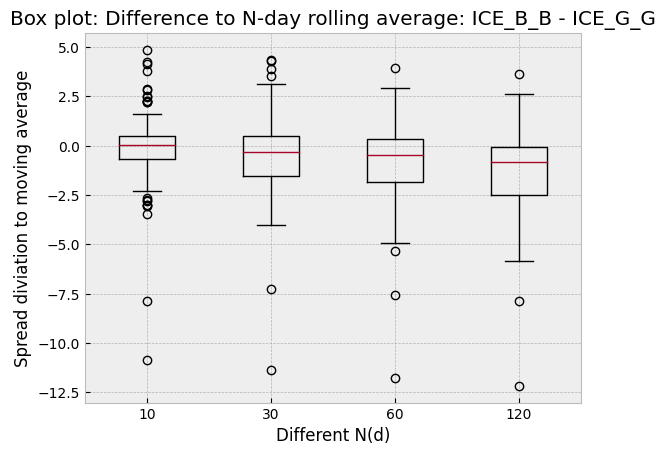

In [135]:
plot_box(D1, "Box plot: Difference to N-day rolling average: ICE_B_B - ICE_G_G", RollingNs)

In [146]:
D2 = S2_avg.iloc[:, 1:].values - S2_avg[["spread"]].values
D2 = pd.DataFrame(D2, columns=["%dD average difference"%day for day in RollingNs])
D2.describe()

,10D average difference,30D average difference,60D average difference,120D average difference
count,371.0000,351.0000,321.0000,261.0000
mean,-0.0929,-0.3161,-0.6437,-1.0871
std,0.2657,0.4818,0.6730,0.9074
min,-1.0935,-1.7571,-2.2572,-3.2222
25%,-0.2584,-0.6243,-1.0672,-1.5485
50%,-0.0667,-0.2842,-0.6204,-1.0378
75%,0.0914,0.0312,-0.1424,-0.5126
max,0.8550,0.8097,0.7331,0.7292


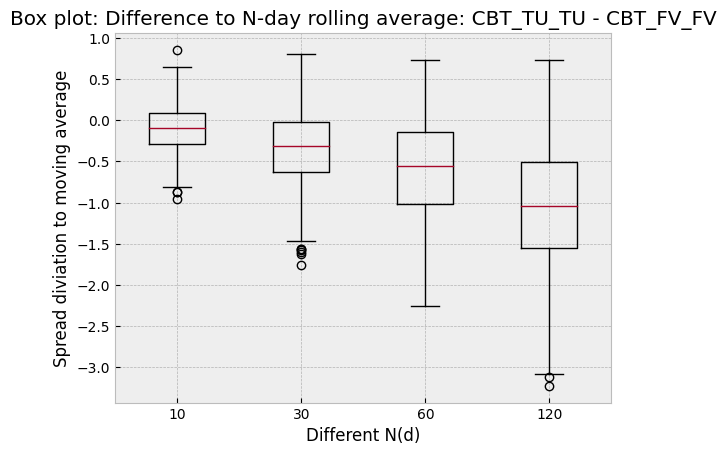

In [137]:
plot_box(D2, "Box plot: Difference to N-day rolling average: CBT_TU_TU - CBT_FV_FV", RollingNs)

## 2.3 Quantiles and Tails

# 2.4 Dynamics
## 2.4.1 Correlations